In [149]:
"""
Preamble for most code and jupyter notebooks
@author: tobinsouth
@notebook date: 16 Nov 2021
"""

import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
import math, string, re, pickle, json, os, sys, datetime, itertools
from collections import Counter
from tqdm import tqdm

# Set panda's options
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 120)

# Better graphics
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('seaborn-poster')

In [230]:
reponse = pd.read_csv('reponse_var.csv')
reponse['tratamiento'] = reponse['tratamiento'].map({1: 'Control', 2: 'Math tutoring', 4: 'Math tutoring', 2: 'Math + emotion learning tutoring'})
# reponse = reponse[~reponse['file'].isna()]

In [167]:
import glob
tokens_by_lesson = {}
for file in glob.glob('data/*.json'):
    with open(file) as f:
        lesson = json.load(f)

        # Some files are empty
        if len(lesson) == 0:
            continue

        lesson_tokens  = [ ]
        for t in lesson['results']:
            words = t['alternatives'][0]['words']
            for word in words:
                lesson_tokens.append((word['word'], word.get('speakerTag', -1)))

        tokens_by_lesson[file.split('/')[-1].split('.')[0]] = lesson_tokens
            

In [169]:
lengths = {lesson:len(lesson_tokens) for lesson, lesson_tokens in tokens_by_lesson.items()}
speaker_counts = {lesson:Counter([s for w,s in lesson_tokens]) for lesson, lesson_tokens in tokens_by_lesson.items()} # Dud

In [170]:
import spacy
nlp = spacy.load("es_core_news_sm")
docs = {lesson:nlp(" ".join([v[0] for v in lesson_tokens]).lower()) for lesson, lesson_tokens in tokens_by_lesson.items()}

In [171]:
person_entity_counts = {lesson:len([ent for ent in doc.ents if ent.label_ == 'PER']) for lesson, doc in docs.items()}
pronoun_counts = {lesson:len([w for w in doc if w.pos_ in ['PRON', 'PROPN']]) for lesson, doc in docs.items()}
numeric_counts = {lesson:len([t for t in doc.text.split() if t.isnumeric()]) for lesson, doc in docs.items()}
non_stop_counts = {lesson:Counter([t.text for t in doc if t.is_stop == False and t.is_punct == False]) for lesson, doc in docs.items()}

In [172]:
word_sum = lambda x: sum([c for t,c in x])
common_ratio = {lesson: word_sum(non_stop.most_common(100))/word_sum(non_stop.most_common()) for lesson, non_stop in non_stop_counts.items() if len(non_stop) > 0}

### Attach to response variables

In [234]:
reponse['file'] = reponse['file'] + '.json'

In [235]:
reponse['lengths']= reponse['file'].map(lengths)
reponse['speaker_counts']= reponse['file'].map(speaker_counts)
reponse['person_entity_counts']= reponse['file'].map(person_entity_counts)
reponse['pronoun_counts']= reponse['file'].map(pronoun_counts)
reponse['numeric_counts']= reponse['file'].map(numeric_counts)
reponse['common_ratio'] = reponse['file'].map(common_ratio)

In [236]:
df = reponse[~reponse['lengths'].isna()]
df = df[df['lengths'] > 100]

In [237]:
import statsmodels.formula.api as smf

# OLS on ChangeMathScore with inputed variables
model = smf.ols(formula='ChangeMathScore ~ lengths + person_entity_counts + pronoun_counts + numeric_counts + common_ratio', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ChangeMathScore   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     2.054
Date:                Wed, 17 Nov 2021   Prob (F-statistic):             0.0797
Time:                        18:10:16   Log-Likelihood:                -125.39
No. Observations:                  87   AIC:                             262.8
Df Residuals:                      81   BIC:                             277.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.6130      1.096     -0.559      0.578      -2.794       1.568
lengths                  0.0002      0.000      1.320      0.191      -0.000       0.001
person_entity_counts     0.0133      0.008      1.601      0.113      -0.003       0.030
pronoun_counts          -0.0010      0.001     -0.706      0.482      -0.004       0.002
numeric_counts          -0.0010      0.001     -1.091      0.279      -0.003       0.001
common_ratio             0.3218      1.356      0.237      0.813      -2.377       3.021
==============================================================================
Omnibus:                        6.892   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                7.088
Skew:                          -0.462   Prob(JB):                       0.0289
Kurtosis:                       4.050   Cond. No.                     8.40e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [289]:
# df.melt(id_vars=['tratamiento'], value_vars=['lengths', 'person_entity_counts', 'pronoun_counts', 'numeric_counts', 'common_ratio'])

In [290]:
df.groupby('tratamiento')['lengths','person_entity_counts','pronoun_counts','numeric_counts','common_ratio'].mean()

/var/folders/53/w69kfwk15djb4p1k1nzr5dzr0000gn/T/ipykernel_82367/350697932.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('tratamiento')['lengths','person_entity_counts','pronoun_counts','numeric_counts','common_ratio'].mean()


lengths  person_entity_counts  \
tratamiento                                                           
Math + emotion learning tutoring  5089.000000             15.416667   
Math tutoring                     5093.684211             22.245614   

                                  pronoun_counts  numeric_counts  common_ratio  
tratamiento                                                                     
Math + emotion learning tutoring      600.666667      263.000000      0.698219  
Math tutoring                         608.035088      268.350877      0.691439

In [291]:
df.groupby('tratamiento')['lengths','person_entity_counts','pronoun_counts','numeric_counts','common_ratio'].std()

/var/folders/53/w69kfwk15djb4p1k1nzr5dzr0000gn/T/ipykernel_82367/2938289726.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('tratamiento')['lengths','person_entity_counts','pronoun_counts','numeric_counts','common_ratio'].std()


lengths  person_entity_counts  \
tratamiento                                                           
Math + emotion learning tutoring  3087.890660              7.959652   
Math tutoring                     2339.979298             18.635872   

                                  pronoun_counts  numeric_counts  common_ratio  
tratamiento                                                                     
Math + emotion learning tutoring      362.430767      201.206362      0.079161  
Math tutoring                         294.321251      142.732078      0.089405

In [238]:
model = smf.ols(formula='ChangeMathScore ~ lengths', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ChangeMathScore   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     6.462
Date:                Wed, 17 Nov 2021   Prob (F-statistic):             0.0128
Time:                        18:10:18   Log-Likelihood:                -127.39
No. Observations:                  87   AIC:                             258.8
Df Residuals:                      85   BIC:                             263.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3966      0.256     -1.549      0.125      -0.906       0.113
lengths        0.0001   4.68e-05      2.542      0.013    2.59e-05       0.000
==============================================================================
Omnibus:                        4.952   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                5.387
Skew:                          -0.269   Prob(JB):                       0.0676
Kurtosis:                       4.094   Cond. No.                     1.23e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

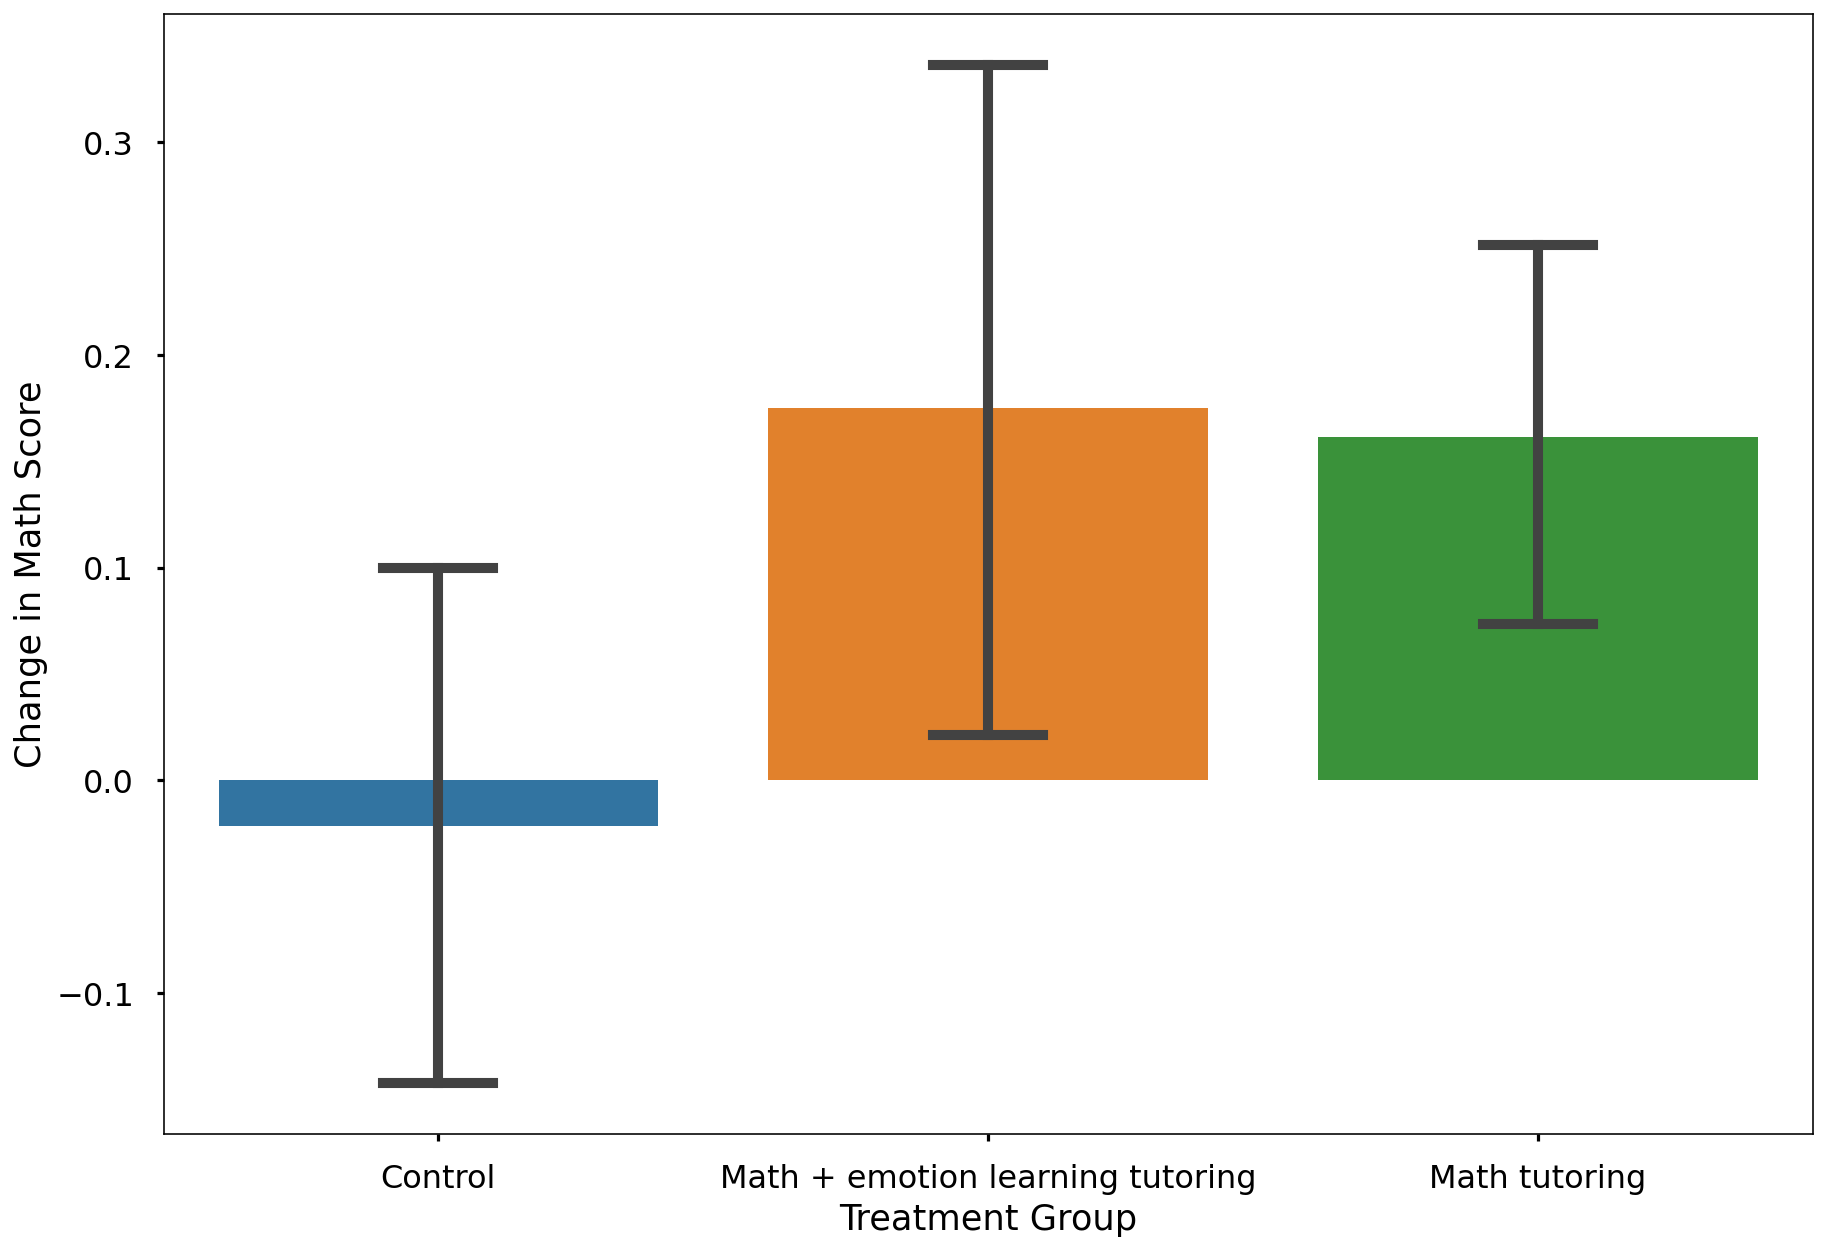

In [281]:
sns.barplot(x='tratamiento', y='ChangeMathScore', data=reponse, ci=90, capsize=.2)
plt.ylabel('Change in Math Score')
plt.xlabel('Treatment Group')
plt.tight_layout()
plt.savefig('ChangeMathScore_by_treatment.png', dpi = 500)

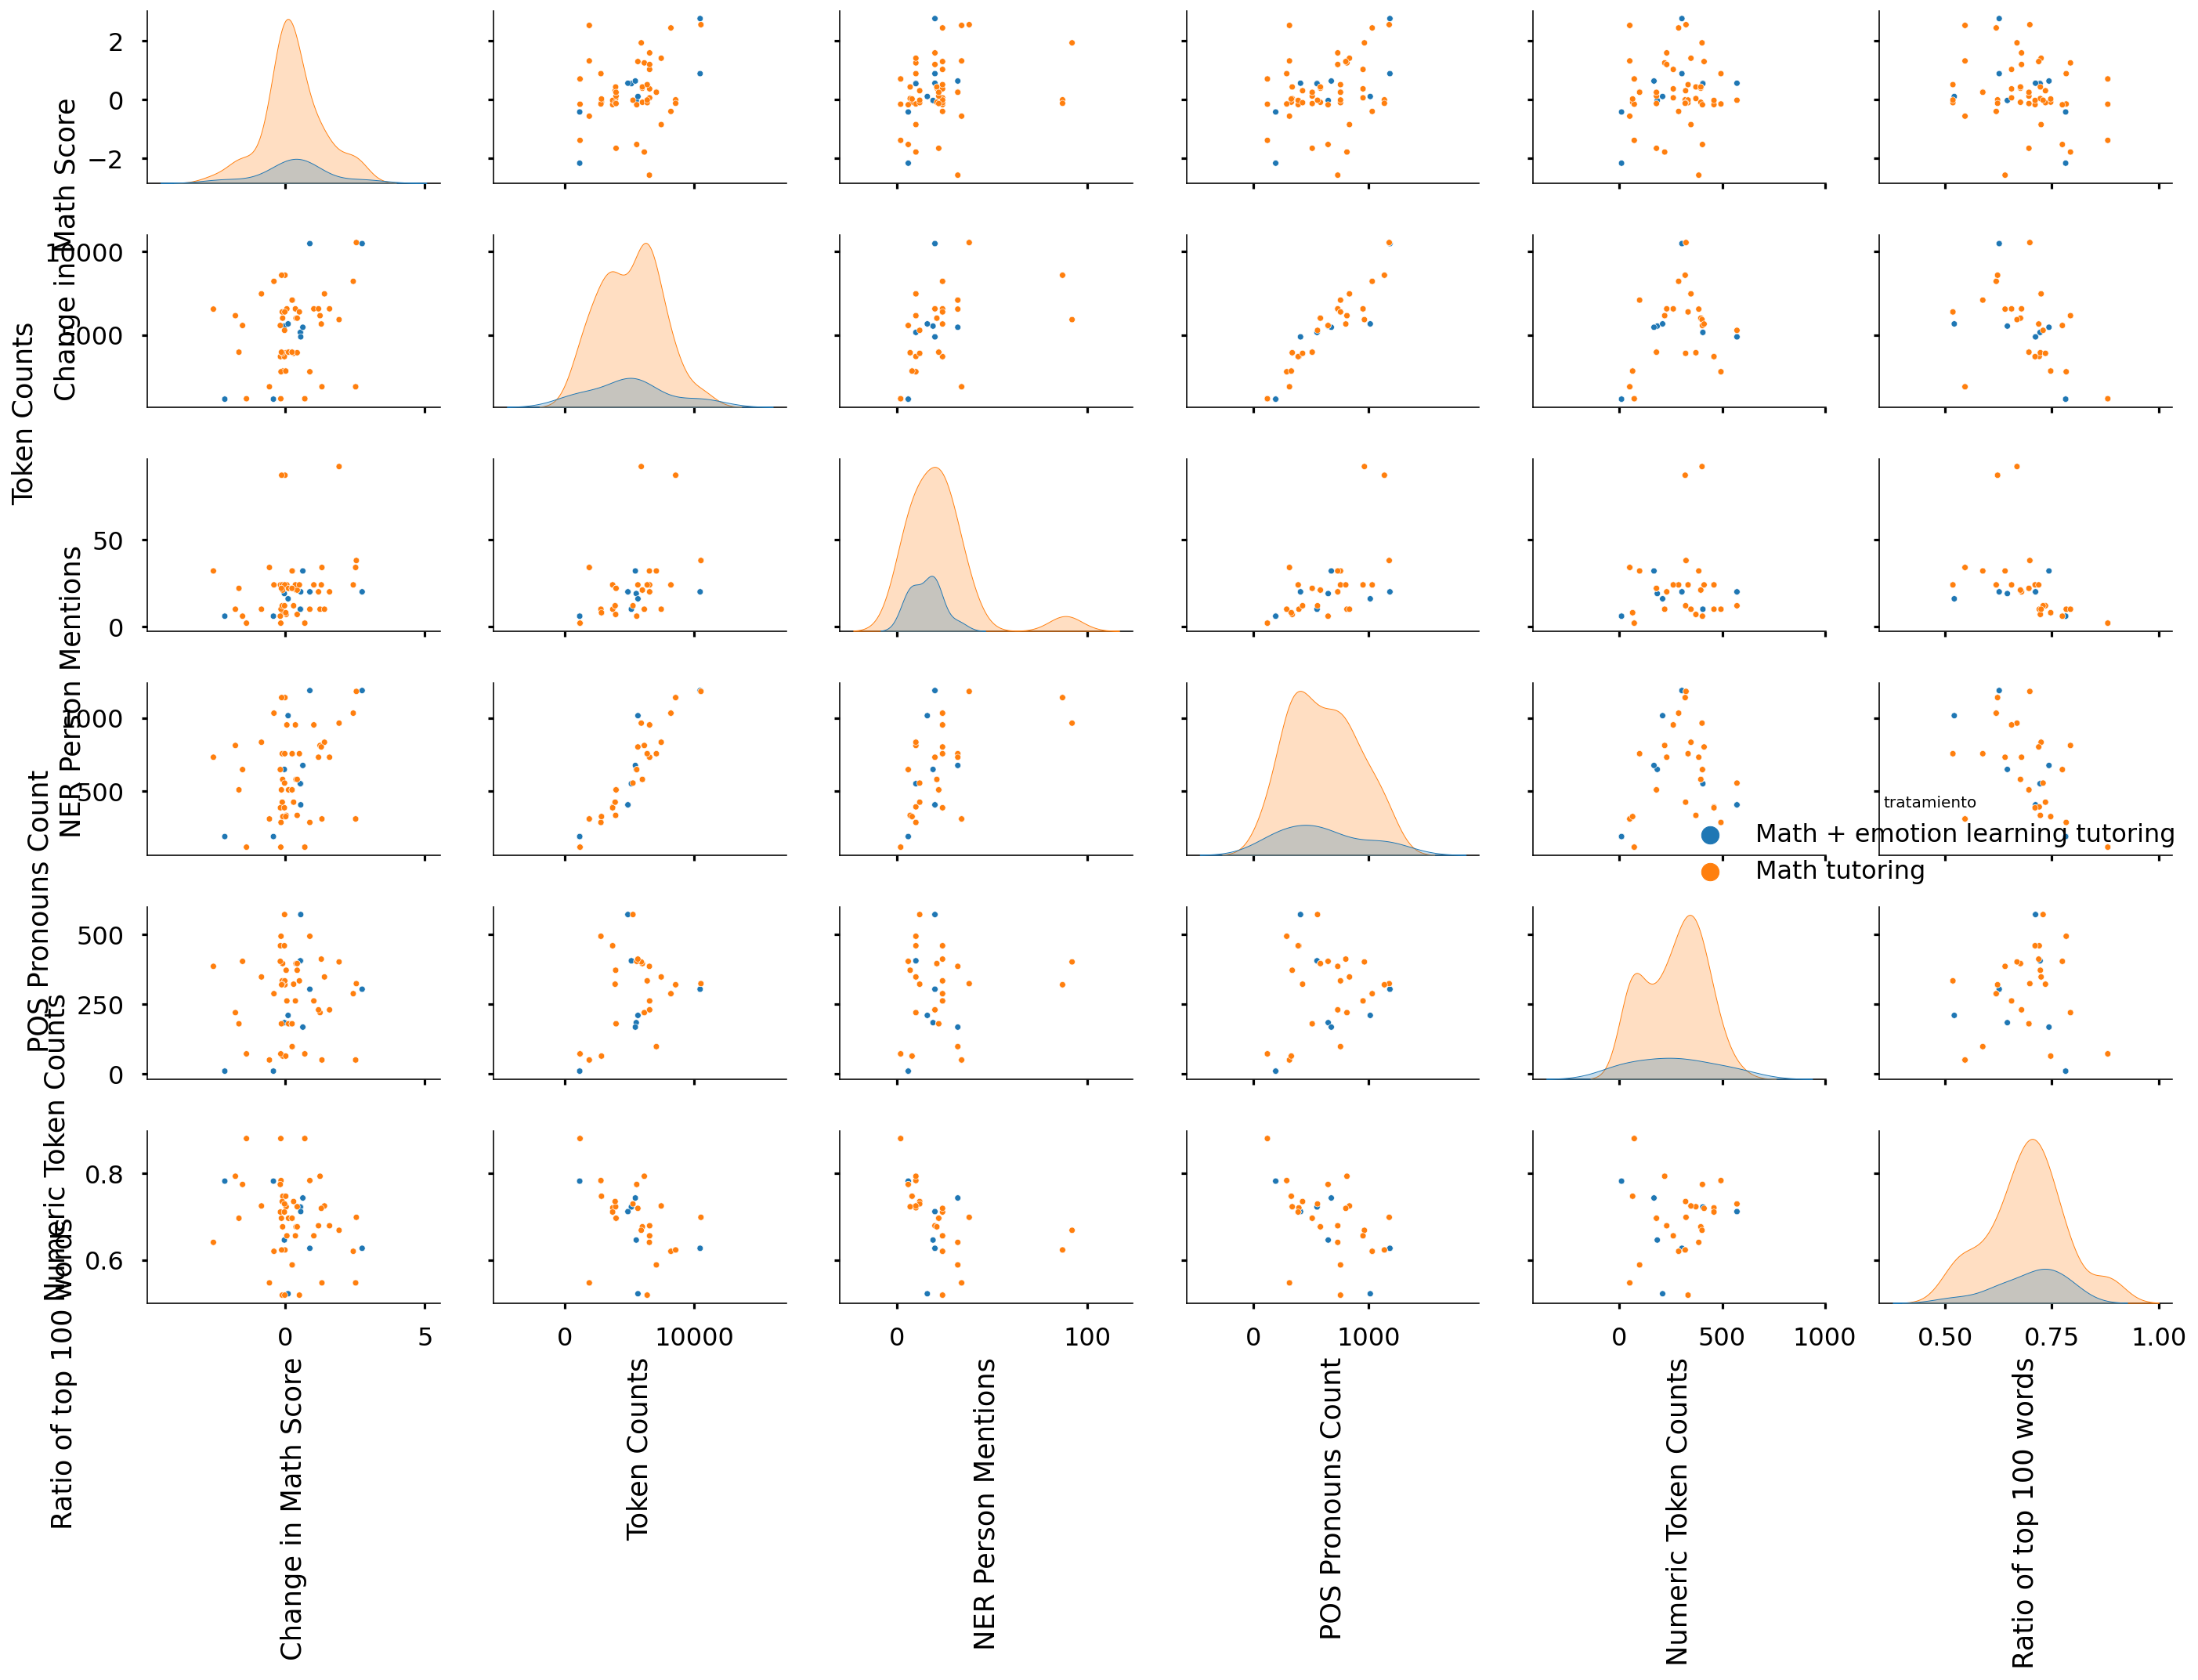

In [280]:
dd_ = df.rename(axis=1, mapper={'ChangeMathScore':  'Change in Math Score', 'lengths': 'Token Counts', 'person_entity_counts':'NER Person Mentions', 'pronoun_counts': 'POS Pronouns Count', 'numeric_counts': 'Numeric Token Counts', 'common_ratio': 'Ratio of top 100 words'})
g = sns.pairplot(dd_, hue='tratamiento', plot_kws={'s':15, 'lw':0}, vars=['Change in Math Score', 'Token Counts', 'NER Person Mentions', 'POS Pronouns Count', 'Numeric Token Counts', 'Ratio of top 100 words'])
for ax in g.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')

# g._legend.set_bbox_to_anchor((0.25, 0.05))
plt.tight_layout()
plt.savefig('pairplot.png', dpi = 500)